#  Exploratory Data Analysis
 
This is the EDA section of a series of notebooks that I created to analyze and forcast the amount of cash one of my ATM machines will dispense.

You can see the whole lifecycle of this project here:

1. [Entire Repo](https://github.com/parkerburchett/Public-ATM)
2. [Data Cleaning](https://github.com/parkerburchett/Public-ATM/blob/main/Clean.Ipynb)
3. [Exploratory Data Analysis](https://github.com/parkerburchett/Public-ATM/blob/main/Exploratory%20Data%20Analysis.ipynb)
4. [Feature Engineering (not finished)](https://github.com/parkerburchett/Public-ATM/blob/main/Feature%20Engineering%20.ipynb)
5. [Modeling (not finished)](https://github.com/parkerburchett/Public-ATM/blob/main/Modeling.ipynb)
 


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Clean Obfuscated ATM Data.csv')
df['Terminal DateTime'] = pd.to_datetime(df['Terminal DateTime']) 
df.set_index(df['Terminal DateTime'], inplace=True)
df = df.loc['2020-8-01':'2021-7-31'] # Subset the data to exclude all non full months

## How large is our data?

In [17]:

print(f'Sample Start: {df.index.min()}')
print(f'Sample End: {df.index.max()}')
print(f'Total Days: {(df.index.max() - df.index.min()).days}')

Sample Start: 2020-08-01 01:04:28
Sample End: 2021-07-31 22:27:20
Total Days: 364


In [18]:
transaction_df = df[df['fee_charged'] != 0.0] # A subset of all the valid transactions
transaction_df.sort_index(inplace=True)
transaction_df.head()


,Customer_id,Terminal DateTime,TranType,Term Seq.,Response,Issuer,amount_requested,amount_dispensed,fee_requested,fee_charged
Terminal DateTime,,,,,,,,,,
2020-08-01 13:13:54,5778876187126349291,2020-08-01 13:13:54,W/D,760.0,Liable,MS0,200.0,200.0,3.0,3.0
2020-08-01 13:14:55,5778876187126349291,2020-08-01 13:14:55,W/D,761.0,Liable,MS0,200.0,200.0,3.0,3.0
2020-08-01 22:17:24,667368338206046387,2020-08-01 22:17:24,W/D,762.0,Liable,MS0,200.0,200.0,3.0,3.0
2020-08-02 00:45:00,5160764800030931563,2020-08-02 00:45:00,W/D,763.0,Approved,MS0,20.0,20.0,3.0,3.0
2020-08-02 12:58:24,7270367318620547036,2020-08-02 12:58:24,W/D,766.0,Liable,PLS,200.0,200.0,3.0,3.0


In [19]:
print(df.shape)
print(transaction_df.shape)

(2536, 10)
(1445, 10)


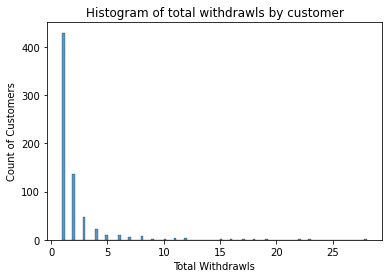

In [20]:
repeat_customers = transaction_df['Customer_id'].value_counts().values
sns.histplot(repeat_customers)
plt.title("Histogram of total withdrawls by customer")
plt.ylabel('Count of Customers')
plt.xlabel('Total Withdrawls')
plt.show()


Most customer only use the ATM once, but there are a handful of customers that have used the ATM many times.

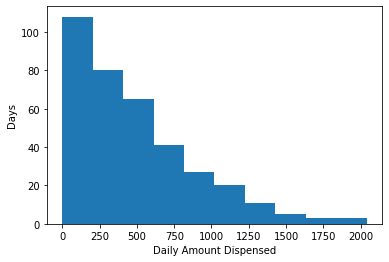

In [21]:
daily_transactions = transaction_df.resample('D').sum()[1:-1]
plt.hist(daily_transactions['amount_dispensed'])
plt.xlabel('Daily Amount Dispensed')
plt.ylabel('Days')
plt.show()

Let's look at what exact kind of distribution this data follows.

[I found a helpful distribution testing library](https://github.com/erdogant/distfit)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000080] [loc=483.196 scale=404.624]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000031] [loc=0.000 scale=483.196]
[distfit] >[pareto    ] [0.02 sec] [RSS: 0.0000186] [loc=-1.926 scale=1.926]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 0.0000074] [loc=414.880 scale=327.494]
[distfit] >[t         ] [0.04 sec] [RSS: 0.0000074] [loc=445.735 scale=397.819]
[distfit] >[genextreme] [0.13 sec] [RSS: 0.0000125] [loc=2.968 scale=17.483]
[distfit] >[gamma     ] [0.05 sec] [RSS: 0.0000039] [loc=-0.000 scale=544.945]
[distfit] >[lognorm   ] [0.08 sec] [RSS: 0.0000151] [loc=-0.000 scale=0.115]
[distfit] >[beta      ] [0.07 sec] [RSS: 0.0000050] [loc=-0.000 scale=4449.515]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000144] [loc=0.000 scale=2040.000]
[distfit] >[loggamma  ] [0.04 sec] [RSS: 0.0000080] [loc=-152596.497 scale=19853.025]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


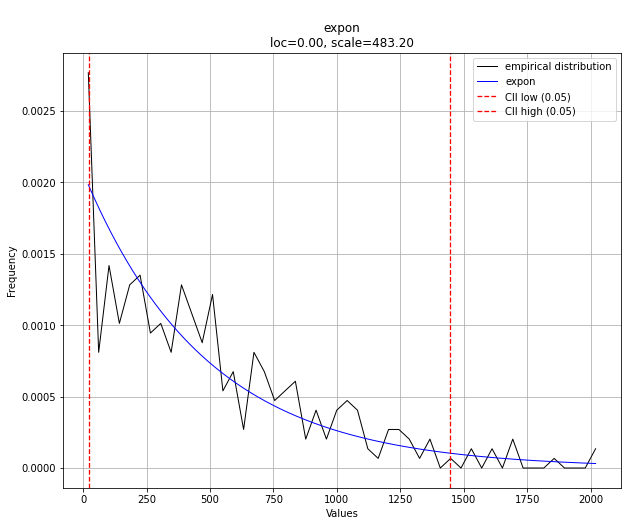

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nexpon\nloc=0.00, scale=483.20'}, xlabel='Values', ylabel='Frequency'>)

In [22]:
from distfit import distfit

dist = distfit()
dist.fit_transform(daily_transactions['amount_dispensed'])
dist.plot()

Daily `amount_dispensed` follows an exponential distribution
 
 
For modeling later we would need to be more sensitive to outliers. This is because I want to avoid running out of cash in the machine.
 
Another option is instead of trying to predict the exact volume of cash to be dispensed, try to predict if a given day will dispense more than ~$1400 and then turn it into a binary classification problem.


# Autocorr

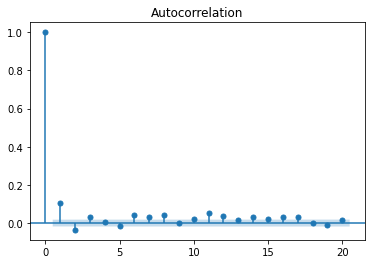

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(transaction_df['amount_dispensed'], lags=20, alpha=.5)
plt.show()

Daily auto corr is near zero for the previous 20 days. A 95% confidence interval contains the 0 at all lags so using daily lagging price indicators does not seem to contain much information

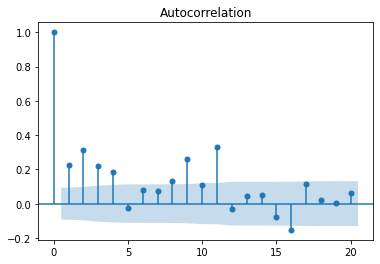

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(transaction_df['amount_dispensed'].resample('W').sum(), lags=20, alpha=.5)
plt.show()

### The weekly auto correlation is much higher and many of the points are outside of the confidence interval. Indicating that there is likly a non spurios relationsship.

In [25]:
total_unique_customers = len(transaction_df['Customer_id'].unique())
number_of_5_plus_repeat_customers = np.sum(transaction_df['Customer_id'].value_counts() >=5)
number_of_5_plus_repeat_customers

print(f'Percent of customers that have used the ATM 5+ times: {round((number_of_5_plus_repeat_customers/total_unique_customers)*100,2)}%')

Percent of customers that have used the ATM 5+ times: 7.55%


In [26]:
customer_group_df = transaction_df.groupby('Customer_id').sum().sort_values(by='fee_charged', ascending=False)
high_freqency_customers = customer_group_df[customer_group_df['fee_charged'] >= 5*3].index
high_freqency_customers[:3]

Int64Index([6151147783377518261, 3187606172919100028, 1079720515450814901], dtype='int64', name='Customer_id')

# Is there any difference between High Frequency and low frequencey Customers

I picked customers with 5 or greater withdrawls to label as High frequency

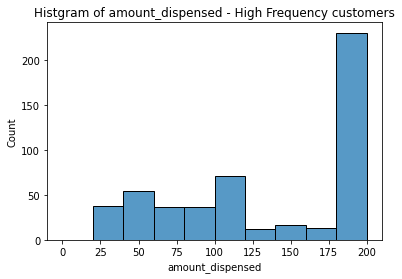

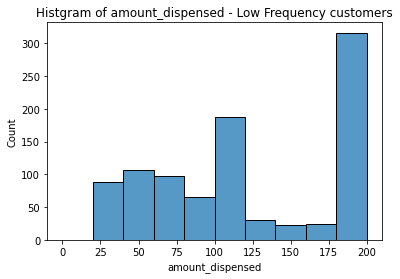

In [27]:
high_frequency_df = transaction_df[transaction_df['Customer_id'].isin(high_freqency_customers)]
low_frequency_df  = transaction_df[~transaction_df['Customer_id'].isin(high_freqency_customers)]

plt.title('Histgram of amount_dispensed - High Frequency customers')
sns.histplot(high_frequency_df['amount_dispensed'], bins=[a for a in range(0,220,20)])
plt.show()

plt.title('Histgram of amount_dispensed - Low Frequency customers')
sns.histplot(low_frequency_df['amount_dispensed'], bins=[a for a in range(0,220,20)])
plt.show()

Low frequency customers tend to take out smaller amounts per transaction

# How did amount dispensed change over time?

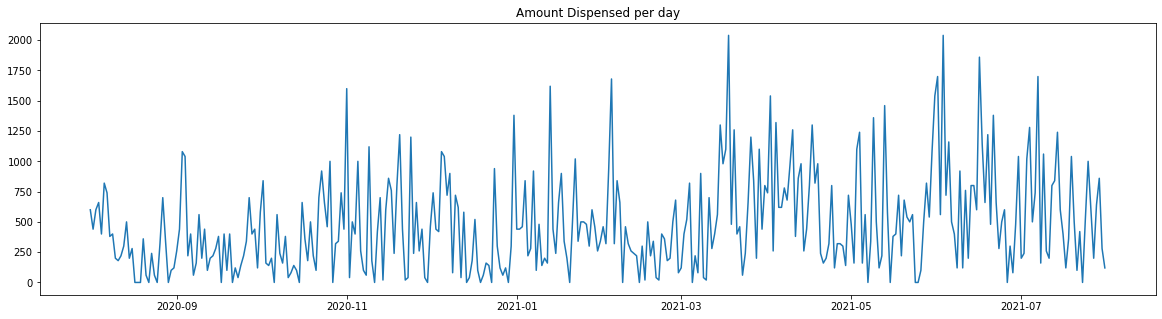

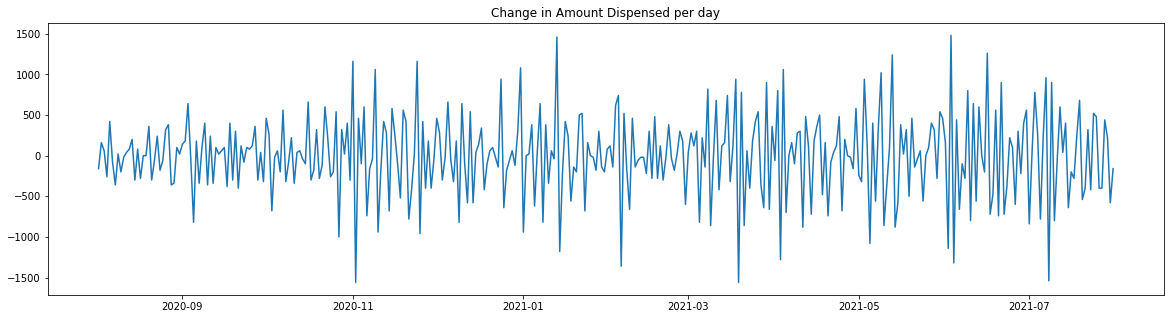

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(transaction_df['amount_dispensed'].resample('D').sum()) 
plt.title('Amount Dispensed per day')
plt.show() 


plt.figure(figsize=(20, 5))
daily_difference = (transaction_df['amount_dispensed'].resample('D').sum()).diff()
plt.plot(daily_difference)
plt.title('Change in Amount Dispensed per day')
plt.show() 

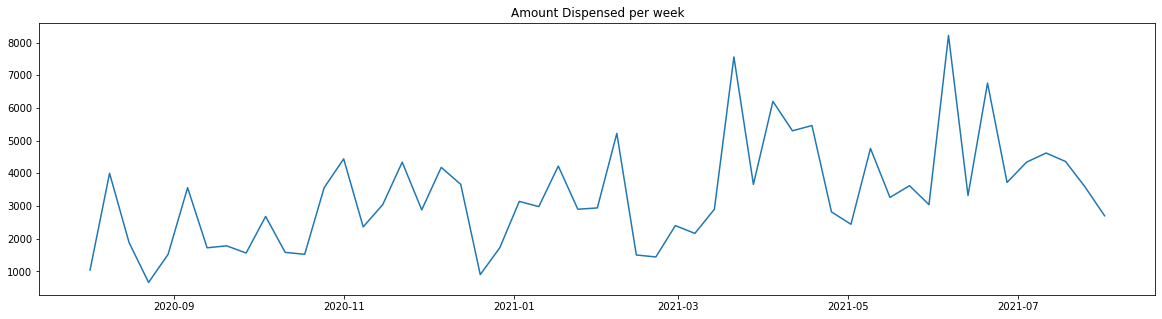

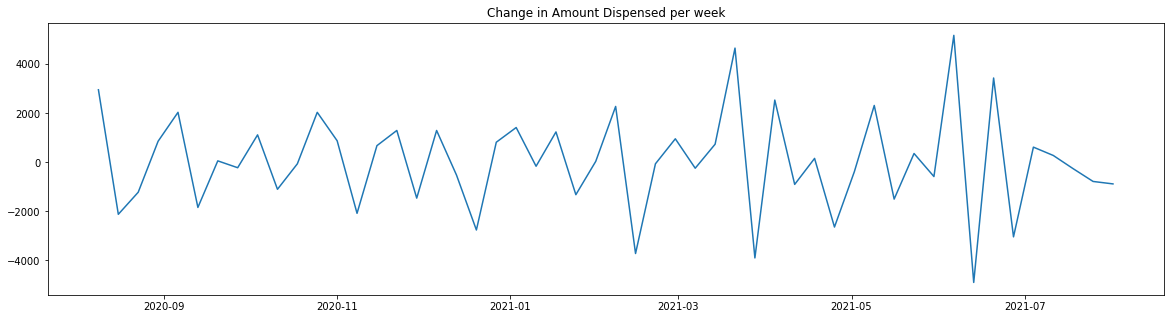

In [29]:
plt.figure(figsize=(20, 5))
plt.plot(transaction_df['amount_dispensed'].resample('w').sum())
plt.title('Amount Dispensed per week')
plt.show() 


plt.figure(figsize=(20, 5))
weekly_difference = (transaction_df['amount_dispensed'].resample('w').sum()).diff()
plt.plot(weekly_difference)
plt.title('Change in Amount Dispensed per week')
plt.show() 

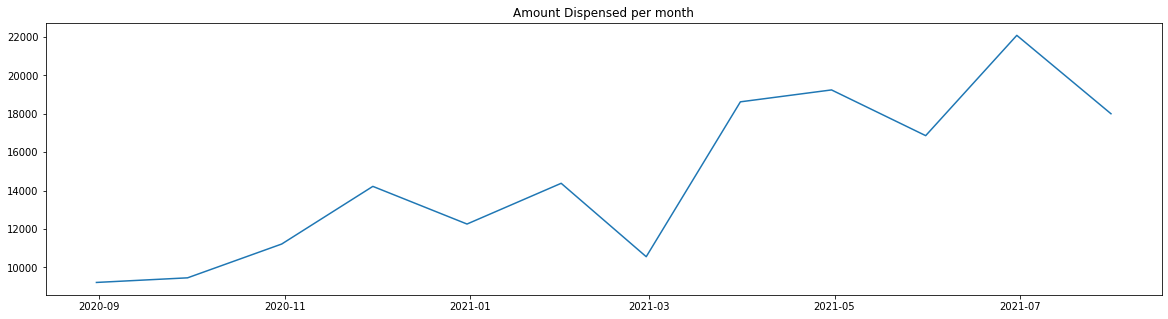

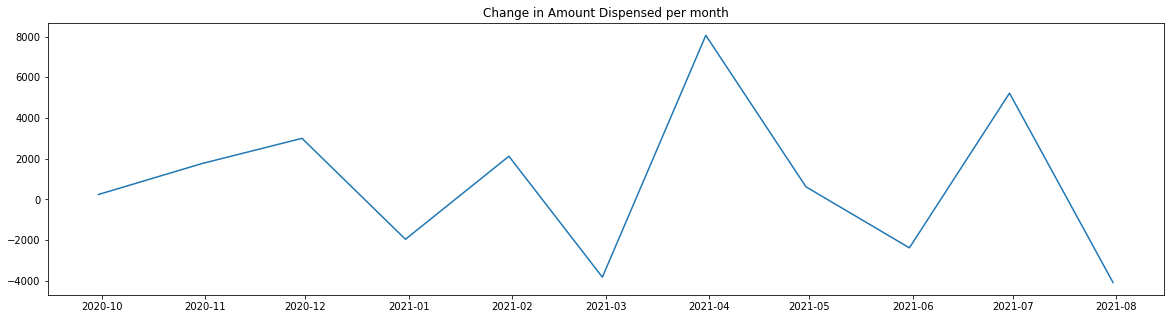

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(transaction_df['amount_dispensed'].resample('m').sum()) 
plt.title('Amount Dispensed per month')
plt.show() 


plt.figure(figsize=(20, 5))
monthly_difference = (transaction_df['amount_dispensed'].resample('m').sum()).diff()
plt.plot(monthly_difference)
plt.title('Change in Amount Dispensed per month')
plt.show() 

# This data is very noisey

Looking at the graphs there seems to be an upward trend in amount dispensed in the last year or so and the daily varience has increased as well. This makes since because the ATM is at a hotel and is more busy now that Washington state is relaxing the pandemic restrictions. 

In [31]:
mean = round(transaction_df['amount_dispensed'].resample('D').sum().mean(),2)
std = round(transaction_df['amount_dispensed'].resample('D').sum().std(),2)

print(f'Average cash withdrawn was ${mean}.')
print(f'STD of daily cash withdrawn was ${std}.')


Average cash withdrawn was $482.52.
STD of daily cash withdrawn was $404.56.


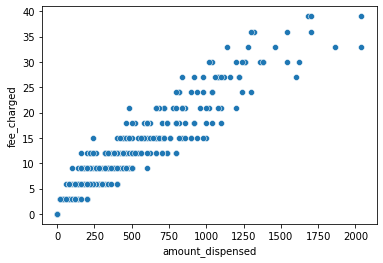

In [32]:
daily_transactions = transaction_df.resample('D').sum()[1:-1]
sns.scatterplot(x='amount_dispensed', y='fee_charged', data=daily_transactions)
plt.show()

There is a positive corrilation between amount dispensed and the fee charged. The varience tends to increase as the amount dispensed increases. This makes senes it is what you would expect since each customer can withdrawl different amounts of cash.

# Conclusions
1. The monthly total amount dispensed has about doubled in the last year from ~$10,000 to ~$20,000.
2. There appears to be a lot of randomness in the daily amount dispensed with the variance increasing in the last few months.
3. The variance of fee charged increases with the amount dispensed.
4. Low frequency customers tend to take out on average less than high frequency customers.
5. The Lifetime transaction count by customer follows an exponential distribution where there are a handful of regular customers and a much larger group of people who only use the ATM once or twice. This again matches intuition since the hotel has regulars who work there and there are a lot of people who are only there for a few nights.
